In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [3]:
data = pd.read_parquet('data/yellow_tripdata_2022-01.parquet')

In [4]:
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,14.5,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,8.0,0.5,0.5,4.00,0.0,0.3,13.30,0.0,0.0
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,7.5,0.5,0.5,1.76,0.0,0.3,10.56,0.0,0.0
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,8.0,0.5,0.5,0.00,0.0,0.3,11.80,2.5,0.0
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,N,68,163,1,23.5,0.5,0.5,3.00,0.0,0.3,30.30,2.5,0.0


In [5]:
data.columns.shape

(19,)

In [6]:
data.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')

In [7]:
x = (data.tpep_dropoff_datetime - data.tpep_pickup_datetime).loc[0]
x.total_seconds()/60

17.816666666666666

In [8]:
data['duration'] = data.tpep_dropoff_datetime - data.tpep_pickup_datetime
data['duration'] = data.duration.apply(lambda duration: duration.total_seconds() / 60)

In [9]:
data.duration.std()

46.44530513776802

In [10]:
data.duration.describe(percentiles=[.1, .2, .3, .25, .50, .75, .98, .99])

count    2.463931e+06
mean     1.421220e+01
std      4.644531e+01
min     -3.442400e+03
10%      4.016667e+00
20%      5.600000e+00
25%      6.316667e+00
30%      7.033333e+00
50%      1.018333e+01
75%      1.616667e+01
98%      4.215000e+01
99%      5.085000e+01
max      8.513183e+03
Name: duration, dtype: float64

<Axes: xlabel='duration', ylabel='Count'>

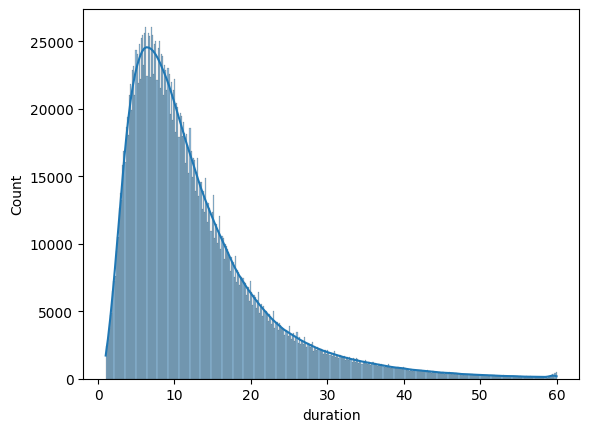

In [11]:
sns.histplot(data[(data.duration >= 1) & (data.duration <= 60)].duration, kde=True)

In [12]:
data[(data.duration >= 1) & (data.duration <= 60)].shape[0] / data.shape[0] * 100

98.27547930522405

In [13]:
data = data[(data.duration >= 1) & (data.duration <= 60)]

In [14]:
data.duration.std()

8.99928164030397

In [15]:
location_features = ['PULocationID', 'DOLocationID']
num_features = ['trip_distance']
target_col = ['duration']

In [16]:
data[location_features] = data[location_features].astype(str)
data[location_features + num_features + target_col].dtypes

PULocationID      object
DOLocationID      object
trip_distance    float64
duration         float64
dtype: object

In [17]:
data.loc[data[location_features[1]].isna(), location_features]

,PULocationID,DOLocationID


In [18]:
def read_data(path):
    data = pd.read_parquet(path)
    data['duration'] = data.tpep_dropoff_datetime - data.tpep_pickup_datetime
    data['duration'] = data.duration.apply(lambda duration: duration.total_seconds() / 60)
    data = data[(data.duration >= 1) & (data.duration <= 60)]

    location_features = ['PULocationID', 'DOLocationID']
    data[location_features] = data[location_features].astype(str)
    
    return data

In [19]:
val_data = read_data('./data/yellow_tripdata_2022-02.parquet')

In [20]:
train_set = data[location_features].to_dict(orient='records')
val_set = val_data[location_features].to_dict(orient='records')

In [21]:
dict_vectorizer = DictVectorizer()
x_train = dict_vectorizer.fit_transform(train_set)

In [22]:
x_val = dict_vectorizer.transform(val_set)

In [23]:
len(dict_vectorizer.feature_names_)

515

In [24]:
target = data[target_col].values
val_target = val_data[target_col].values

In [25]:
lr = LinearRegression()
lr.fit(x_train, target)

LinearRegression()

In [26]:
mean_squared_error(target, lr.predict(x_train), squared=False)

6.986191073363653

In [27]:
mean_squared_error(val_target, lr.predict(x_val), squared=False)

7.786411055870005

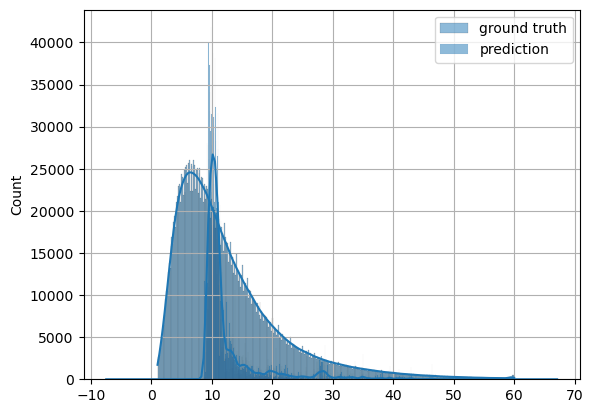

In [27]:
sns.histplot(target, kde=True, label='ground truth')
sns.histplot(lr.predict(x_train), kde=True, label='prediction')
plt.legend()
plt.grid()

In [28]:
lr.predict(x_train).max(), lr.predict(x_train).min()

(67.10893877254088, -7.4907455804205085)

### combine features

In [29]:
data['PU_DU'] = data.PULocationID + '_' + data.DOLocationID
val_data['PU_DU'] = val_data.PULocationID + '_' + val_data.DOLocationID

In [30]:
train_set = data[['PU_DU']].to_dict(orient='records')
val_set = val_data[['PU_DU']].to_dict(orient='records')
dict_vectorizer = DictVectorizer()
x_train = dict_vectorizer.fit_transform(train_set)

In [31]:
x_val = dict_vectorizer.transform(val_set)

In [32]:
lr = LinearRegression()
lr.fit(x_train, target)

LinearRegression()

In [33]:
mean_squared_error(target, lr.predict(x_train), squared=False)

4.564964508540252

In [34]:
mean_squared_error(val_target, lr.predict(x_val), squared=False)

5.41511192973617